In [1]:
%pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchinfo import summary
from model import Model_01 as Net

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

# Test Phase transformations
test_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

In [4]:
train = datasets.MNIST("./data", train=True, download=True, transform=train_transforms)
test = datasets.MNIST("./data", train=False, download=True, transform=test_transforms)

In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = (
    dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True)
    if cuda
    else dict(shuffle=True, batch_size=64)
)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


torch.Size([60000, 28, 28])
torch.Size([28, 60000, 28])
[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


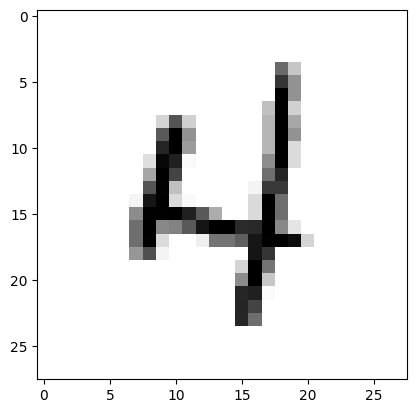

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.data
train_data = train.transform(train_data.numpy())

print(train.data.shape)
print(train_data.shape)

print('[Train]')
print(' - Numpy Shape:', train.data.cpu().numpy().shape)
print(' - Tensor Shape:', train.data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

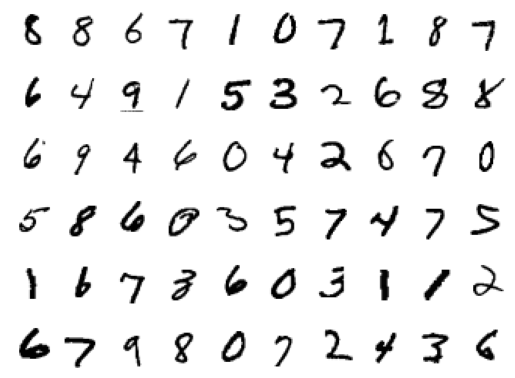

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis("off")
    plt.imshow(images[index].numpy().squeeze(), cmap="gray_r")

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(256, 512, 3)
        self.conv6 = nn.Conv2d(512, 1024, 3)
        self.conv7 = nn.Conv2d(1024, 10, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        x = self.conv7(x)
        x = x.view(-1, 10)  # 1x1x10> 10
        return F.log_softmax(x, dim=-1)

# Receptive Field Calculations for all layers.

n_in | RF_in | k | p | s | J_in | J_out | RF_out | n_out | layer
-----|-------|---|---|---|------|-------|--------|-------|---------
28   |   1   | 3 | 1 | 1 | 1    |   1   |   3    |  28   | conv1
28   |   3   | 3 | 1 | 1 | 1    |   1   |   5    |  28   | conv2
28   |   5   | 2 | 0 | 2 | 1    |   2   |   6    |  14   | pool1
14   |   6   | 3 | 1 | 1 | 2    |   2   |   10   |  14   | conv3
14   |   10  | 3 | 1 | 1 | 2    |   2   |   14   |  14   | conv4
14   |   14  | 2 | 0 | 2 | 2    |   4   |   16   |   7   | pool2
 7   |   16  | 3 | 0 | 1 | 4    |   4   |   24   |   5   | conv5
 5   |   24  | 3 | 0 | 1 | 4    |   4   |   32   |   3   | conv6
 3   |   32  | 3 | 0 | 1 | 4    |   4   |   40   |   1   | conv7

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
batch_size = 20
s = summary(
    model,
    input_size=(batch_size, 1, 28, 28),
    verbose=1,
    col_names=[
        "kernel_size",
        "input_size",
        "output_size",
        "num_params",
        "mult_adds",
        "trainable",
    ],
    row_settings=["var_names"],
)

cuda
Layer (type (var_name))                  Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds                 Trainable
Net (Net)                                --                        [20, 1, 28, 28]           [20, 10]                  --                        --                        True
├─Conv2d (conv1)                         [3, 3]                    [20, 1, 28, 28]           [20, 32, 28, 28]          320                       5,017,600                 True
├─Conv2d (conv2)                         [3, 3]                    [20, 32, 28, 28]          [20, 64, 28, 28]          18,496                    290,017,280               True
├─MaxPool2d (pool1)                      2                         [20, 64, 28, 28]          [20, 64, 14, 14]          --                        --                        --
├─Conv2d (conv3)                         [3, 3]                    [20, 64, 14, 14]          [20, 128, 14, 14]  

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

epoch_train_acc = []


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(
            dim=1, keepdim=True
        )  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(
            desc=f"Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}"
        )
        train_acc.append(100 * correct / processed)

    # epoch accuracy = accuracy for the whole batch
    epoch_train_acc.append(100 * correct / processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

    test_acc.append(100.0 * correct / len(test_loader.dataset))

In [11]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.08843976259231567 Batch_id=468 Accuracy=87.66: 100%|██████████| 469/469 [00:13<00:00, 35.76it/s] 


Test set: Average loss: 0.0573, Accuracy: 9823/10000 (98.23%)

EPOCH: 1


Loss=0.03120739944279194 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:12<00:00, 38.08it/s] 


Test set: Average loss: 0.0380, Accuracy: 9883/10000 (98.83%)

EPOCH: 2


Loss=0.017138347029685974 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:12<00:00, 38.96it/s] 


Test set: Average loss: 0.0359, Accuracy: 9891/10000 (98.91%)

EPOCH: 3


Loss=0.03464527055621147 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:12<00:00, 38.42it/s]  


Test set: Average loss: 0.0297, Accuracy: 9911/10000 (99.11%)

EPOCH: 4


Loss=0.04792313277721405 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:12<00:00, 38.69it/s]  


Test set: Average loss: 0.0309, Accuracy: 9901/10000 (99.01%)

EPOCH: 5


Loss=0.00911226961761713 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:12<00:00, 37.66it/s]   


Test set: Average loss: 0.0272, Accuracy: 9913/10000 (99.13%)

EPOCH: 6


Loss=0.007010536268353462 Batch_id=468 Accuracy=99.64: 100%|██████████| 469/469 [00:11<00:00, 39.13it/s]  


Test set: Average loss: 0.0324, Accuracy: 9906/10000 (99.06%)

EPOCH: 7


Loss=0.0004450833366718143 Batch_id=468 Accuracy=99.72: 100%|██████████| 469/469 [00:11<00:00, 39.18it/s] 


Test set: Average loss: 0.0319, Accuracy: 9908/10000 (99.08%)

EPOCH: 8


Loss=0.02377527952194214 Batch_id=468 Accuracy=99.81: 100%|██████████| 469/469 [00:11<00:00, 40.10it/s]   


Test set: Average loss: 0.0278, Accuracy: 9918/10000 (99.18%)

EPOCH: 9


Loss=0.0013153107138350606 Batch_id=468 Accuracy=99.83: 100%|██████████| 469/469 [00:11<00:00, 39.49it/s] 


Test set: Average loss: 0.0316, Accuracy: 9916/10000 (99.16%)

EPOCH: 10


Loss=0.0017768923426046968 Batch_id=468 Accuracy=99.84: 100%|██████████| 469/469 [00:11<00:00, 39.67it/s] 


Test set: Average loss: 0.0312, Accuracy: 9919/10000 (99.19%)

EPOCH: 11


Loss=0.0012568241218104959 Batch_id=468 Accuracy=99.87: 100%|██████████| 469/469 [00:11<00:00, 39.76it/s] 


Test set: Average loss: 0.0407, Accuracy: 9889/10000 (98.89%)

EPOCH: 12


Loss=0.00038282768218778074 Batch_id=468 Accuracy=99.90: 100%|██████████| 469/469 [00:12<00:00, 38.67it/s]


Test set: Average loss: 0.0284, Accuracy: 9931/10000 (99.31%)

EPOCH: 13


Loss=0.0002700217009987682 Batch_id=468 Accuracy=99.93: 100%|██████████| 469/469 [00:11<00:00, 39.73it/s] 


Test set: Average loss: 0.0374, Accuracy: 9914/10000 (99.14%)

EPOCH: 14


Loss=0.00018314289627596736 Batch_id=468 Accuracy=99.92: 100%|██████████| 469/469 [00:11<00:00, 39.60it/s]


Test set: Average loss: 0.0340, Accuracy: 9920/10000 (99.20%)



Text(0.5, 1.0, 'Test Accuracy')

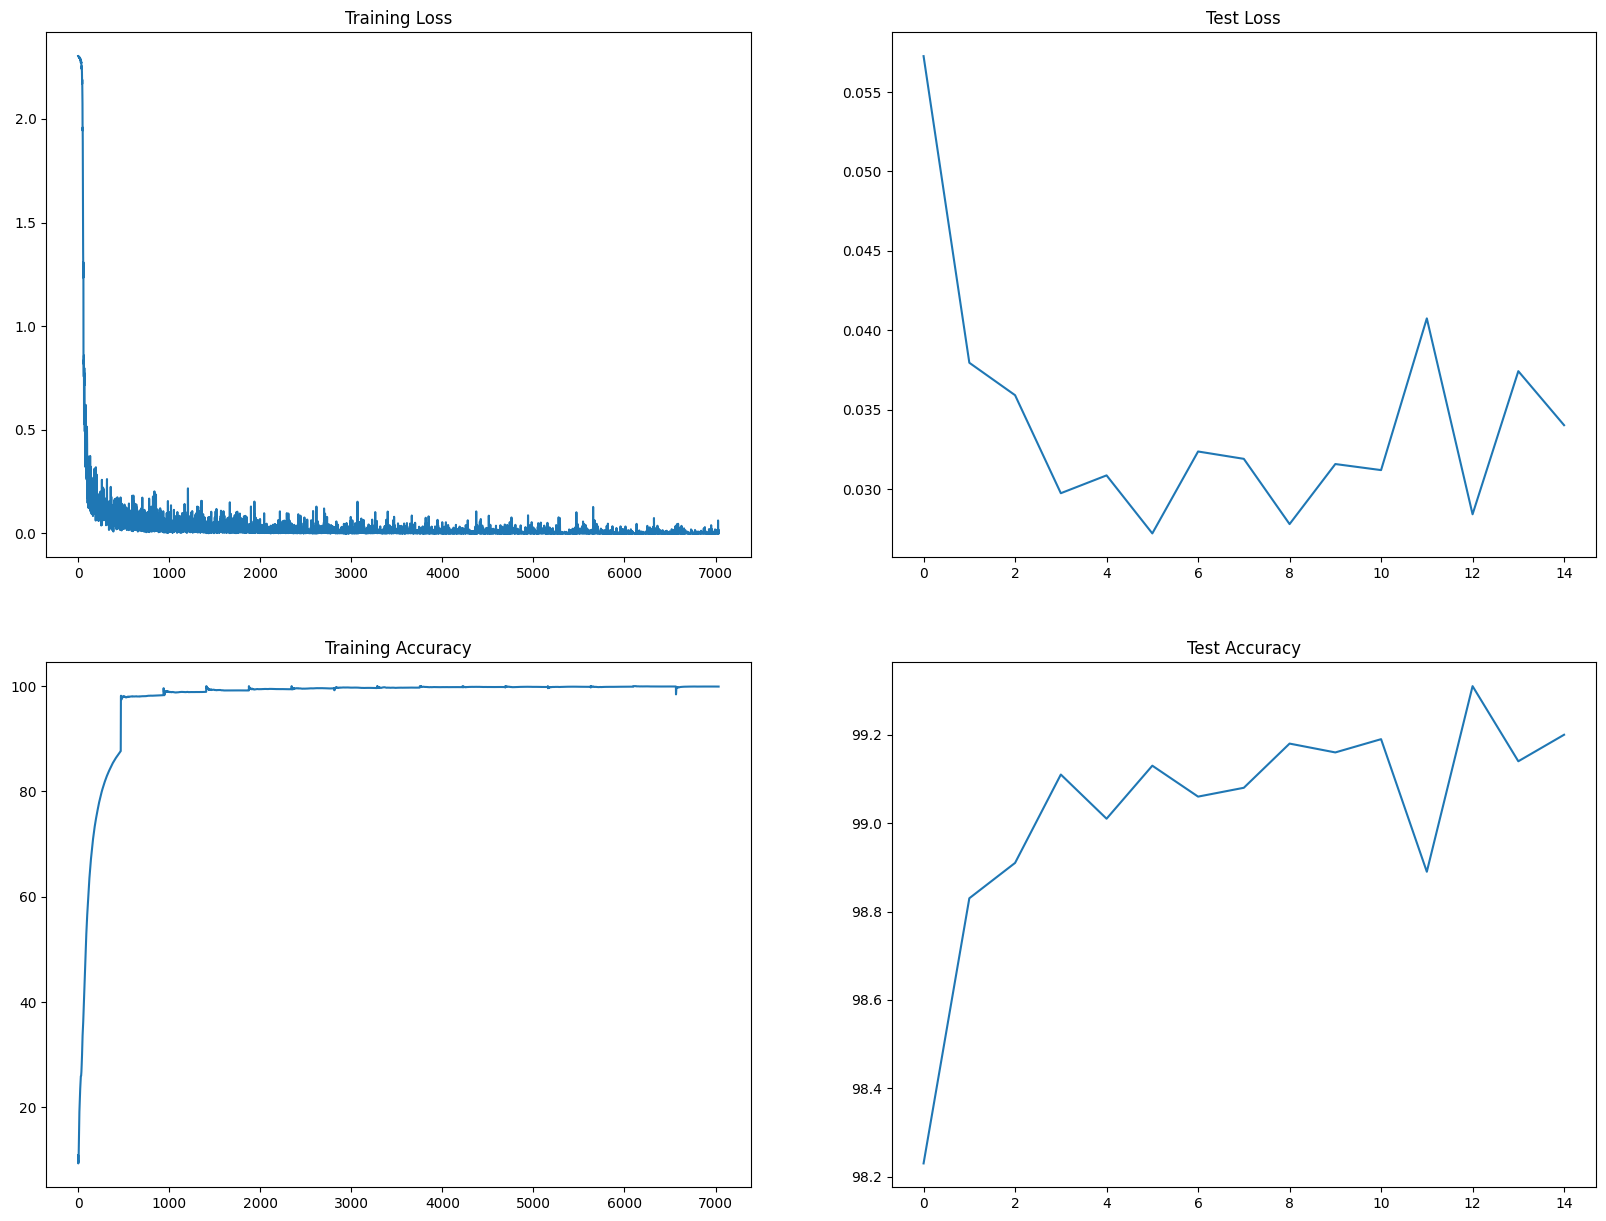

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [13]:
print("Minimum training loss = {:.9f}%".format(min(train_losses)))
print("Minimum testing loss = {:.9f}%".format(min(test_losses)))
print("Best training accuracy = {:.2f}%".format(max(epoch_train_acc)))
print("Best testing accuracy = {:.2f}%".format(max(test_acc)))

Minimum training loss = 0.000002812%
Minimum testing loss = 0.027205948%
Best training accuracy = 99.93%
Best testing accuracy = 99.31%



# Target:

1.  Get the set-up right
2.  Set Transforms
3.  Set Data Loader
4.  Set Basic Working Code
5.  Set Basic Training  & Test Loop

# Results:

*   Parameters = 6,379,786
*   Best training accuracy = 99.93%
*   Best testing accuracy = 99.31%

# Analysis:

*   Extremely Heavy Model for such a problem
*   Model is over-fitting
*   This was just to setup the structure of the code and we'll improve upon it in later iterations